In [73]:
# crossings = []
# mid_points = []
# for perm in combinations(planes.values(), 2):
#     n1, n2 = perm[0].norm, perm[1].norm
#     # cross product automatically weighs in the angle between
#     # the two vectors: narrower angles have less impact,
#     # perpendicular vectors have the most
#     crossing = np.cross(n1, n2)

#     # two great circles cross each other twice (one would be
#     # the origin, the other one the direction of the gamma) it
#     # doesn't matter which we pick but it should at least be
#     # consistent: make sure to always take the "upper" solution
#     if crossing[2] < 0:
#         crossing *= -1
#     crossings.append(crossing)
#     mid_point = (perm[0].pos + perm[1].pos) / 2
#     mid_points.append(mid_point)
# crossings = np.array(crossings)
# mid_points = np.array(mid_points)

# crossings.shape

In [1]:
%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.utils import get_dataset
from ctapipe.image import tailcuts_clean
from ctapipe.reco import HillasReconstructor
from ctapipe.image import hillas_parameters
from ctapipe.visualization import ArrayDisplay
from ctapipe.coordinates import TiltedGroundFrame
from itertools import combinations
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import copy
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

from ctapipe.instrument import get_atmosphere_profile_functions

%matplotlib inline

In [2]:
filename='../prod3/gamma/gamma_20deg_0deg_run501___cta-prod3-merged_desert-2150m-Paranal-3HB89-NGFD.simtel.gz'
# filename='../gamma_20deg_0deg_run4602___cta-prod3-merged_desert-2150m-Paranal-3HB89-NGFD_cone10.simtel.gz'
source = event_source(filename)
source.max_events = 10
events = [copy.deepcopy(event) for event in tqdm(source)]

# Calibration
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')
    
# ## Find "big" event
# events_amplitude = []
# for event in tqdm(events):
#     event_amplitude = 0
#     for tel_id in event.r0.tels_with_data:
#         if event.dl1.tel[tel_id].image is not None:
#             event_amplitude += event.dl1.tel[tel_id].image[0].sum()
#     events_amplitude.append(event_amplitude)
# events_amplitude = np.array(events_amplitude)

# mm = events_amplitude.argmax()
# print(mm)
# event = events[mm]



10it [00:02,  4.73it/s]


In [3]:
class HillasNotFinite(Exception):
    """
    Error to be raised when hillas parameters are not finite
    """
    pass


allowed_cameras = ['LSTCam', 'NectarCam', 'DigiCam']

cleaning_level = {
    # 'ASTRICam': (5, 7, 2),  # (5, 10)?
    # 'FlashCam': (12, 15, 2),
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    # ASWG Zeuthen talk by Abelardo Moralejo:
    'NectarCam': (3, 5.5, 2),
    # "FlashCam": (4, 8),  # there is some scaling missing?
    'DigiCam': (2, 4.5, 2),
    # 'CHEC': (2, 4, 2),
    # 'SCTCam': (1.5, 3, 2)
}

def reconstruction(event):
      
    features = {}
    hillas_dict = {}
    pointing_azimuth = {}
    pointing_altitude = {}
    
    for tel_id in event.r0.tels_with_data:
        camera = event.inst.subarray.tels[tel_id].camera
        if camera.cam_id not in allowed_cameras:
            print('Shitty camera')
            continue
            
        boundary_thresh, picture_thresh, min_number_picture_neighbors = cleaning_level[camera.cam_id]

        dl1 = event.dl1.tel[tel_id]
        camera = event.inst.subarray.tels[tel_id].camera
        mask = tailcuts_clean(camera, dl1.image[0], 
                               boundary_thresh=boundary_thresh, 
                              picture_thresh=picture_thresh, 
                              min_number_picture_neighbors=min_number_picture_neighbors)
        telescope_type_name = event.inst.subarray.tels[tel_id].optics.tel_type
        dl1.cleaned = copy.copy(dl1.image[0])
        cleaned = dl1.cleaned
        cleaned[~mask] = 0
        
        if cleaned.sum() > 0:
            try:
                h = hillas_parameters(
                    camera,
                    cleaned
                )

                if not all(map(np.isfinite, h.values())):
                    raise HillasNotFinite("bad Hillas parameters")

                hillas_dict[tel_id] = h
                pointing_azimuth[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
                pointing_altitude[tel_id] = event.mc.tel[tel_id].altitude_raw* u.rad  
    
            except HillasNotFinite:
                pass
                
        else:
            pass

    if len(hillas_dict) < 2:
#         print("mono")
        reconstruction = None
        return None, None
    else:
#         print(len(hillas_dict))
        reconstruction = hillas_reco.predict(hillas_dict, event.inst, pointing_altitude, pointing_azimuth)
    return reconstruction, hillas_dict, event


In [4]:
def line_line_intersection_3d(uvw_vectors, origins):
    C = []
    S = []
    for n, pos in zip(uvw_vectors, origins):
        n = n.reshape((3, 1))
        norm_matrix = n@n.T - np.eye(3)
        C.append(norm_matrix@pos)    
        S.append(norm_matrix)

    S = np.array(S).sum(axis=0)
    C = np.array(C).sum(axis=0)
    return np.linalg.inv(S)@C

def reconstruct_impact_position(hillas_dict, subarray):
    # build uvw vectors by converting from polar to cartesian. the z is fixed at z = 0
    uvw_vectors = np.array([(np.cos(h.phi), np.sin(h.phi), 0 )for h in hillas_dict.values()])
    positions = [event.inst.subarray.positions[tel_id].value for tel_id in hillas_dict]
    
    return line_line_intersection_3d(uvw_vectors, positions)[:2]

# lsqr_impact = reconstruct_impact_position(hillas_dict, event.inst.subarray)
# lsqr_impact

In [92]:
cal.calibrate(events[0])
reco, hillas_dict, event = reconstruction(events[0])

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


In [95]:
event.r0.event_id,  event.trig.tels_with_trigger, event.mc.energy

(2504, array([  1, 103, 107, 109, 116, 119,   8,  12,  14,  21,  24,  38, 133,
         86, 181], dtype=int32), <Quantity 0.57373291 TeV>)

In [94]:
hillas_dict[1].phi, hillas_dict[1].x

(<Angle 0.72483802 rad>, <Quantity 0.75966535 m>)

In [87]:
hillas_dict.keys()

dict_keys([1, 8, 12, 14, 21, 24, 181])

In [29]:
old_d = []
new_d = []
es = []
# Hillas reconstruction
for event in tqdm(events):
    cal.calibrate(event)
    reco, hillas_dict = reconstruction(event)
    if not reco:
        continue
#     plt.figure()
    lsqr_impact = reconstruct_impact_position(hillas_dict, event.inst.subarray)
    lsqr_distance = np.sqrt((event.mc.core_x - lsqr_impact[0] * u.m)**2 + (event.mc.core_y - lsqr_impact[1] * u.m)**2)
    distance = np.sqrt((event.mc.core_x - reco.core_x)**2 + (event.mc.core_y - reco.core_y)**2)
#     print(lsqr_distance)
#     print(distance)
    es.append(event.mc.energy.value)
    old_d.append(distance.value)
    new_d.append(lsqr_distance.value)
    
print(f'New: {np.mean(new_d)}')
print(f'Old: {np.mean(old_d)}')
#     plot_array_impact(event, hillas_dict, lsqr_impact)

  0%|          | 0/975 [00:00<?, ?it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  0%|          | 1/975 [00:00<09:53,  1.64it/s]

Shitty camera
Shitty camera


  0%|          | 2/975 [00:01<09:47,  1.66it/s]

Shitty camera
Shitty camera
Shitty camera


  0%|          | 3/975 [00:01<08:48,  1.84it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


  0%|          | 4/975 [00:02<08:16,  1.96it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera


  1%|          | 5/975 [00:02<07:45,  2.09it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  1%|          | 6/975 [00:03<08:21,  1.93it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  1%|          | 7/975 [00:03<09:24,  1.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


  1%|          | 8/975 [00:05<13:31,  1.19it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  1%|          | 12/975 [00:05<10:06,  1.59it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  1%|▏         | 14/975 [00:06<09:14,  1.73it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  2%|▏         | 15/975 [00:07<10:00,  1.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  2%|▏         | 16/975 [00:09<18:52,  1.18s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


  2%|▏         | 20/975 [00:11<14:48,  1.08it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  2%|▏         | 22/975 [00:11<11:37,  1.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  2%|▏         | 23/975 [00:12<11:56,  1.33it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  2%|▏         | 24/975 [00:13<11:53,  1.33it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  3%|▎         | 27/975 [00:14<09:35,  1.65it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  3%|▎         | 28/975 [00:14<09:43,  1.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  3%|▎         | 29/975 [00:15<08:51,  1.78it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  3%|▎         | 31/975 [00:15<07:39,  2.05it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera


  3%|▎         | 33/975 [00:16<06:16,  2.50it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  4%|▎         | 36/975 [00:17<05:43,  2.74it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  4%|▍         | 39/975 [00:18<05:01,  3.10it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  4%|▍         | 40/975 [00:18<05:37,  2.77it/s]

Shitty camera


  4%|▍         | 42/975 [00:19<05:32,  2.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  4%|▍         | 43/975 [00:19<06:05,  2.55it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  5%|▍         | 44/975 [00:21<10:32,  1.47it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  5%|▍         | 45/975 [00:21<10:27,  1.48it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera


  5%|▍         | 46/975 [00:22<08:45,  1.77it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


  5%|▌         | 49/975 [00:22<06:39,  2.32it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


  5%|▌         | 50/975 [00:22<05:59,  2.58it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


  5%|▌         | 53/975 [00:23<04:45,  3.23it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  6%|▌         | 54/975 [00:23<06:00,  2.55it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  6%|▌         | 58/975 [00:24<05:08,  2.98it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  6%|▌         | 60/975 [00:24<04:29,  3.39it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 64/975 [00:25<03:37,  4.20it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 65/975 [00:25<04:02,  3.75it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 67/975 [00:26<03:46,  4.01it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 69/975 [00:26<03:16,  4.61it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 70/975 [00:26<03:26,  4.38it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 71/975 [00:26<03:38,  4.13it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  7%|▋         | 73/975 [00:27<04:32,  3.31it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 74/975 [00:28<05:50,  2.57it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 76/975 [00:28<04:40,  3.20it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 78/975 [00:28<03:54,  3.83it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 79/975 [00:29<03:43,  4.01it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 80/975 [00:29<04:52,  3.06it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  8%|▊         | 81/975 [00:29<04:44,  3.14it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  9%|▊         | 85/975 [00:30<03:48,  3.90it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  9%|▉         | 86/975 [00:30<04:02,  3.67it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  9%|▉         | 87/975 [00:31<06:36,  2.24it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
  9%|▉         | 92/975 [00:32<05:00,  2.94it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 10%|▉         | 93/975 [00:33<09:32,  1.54it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 10%|▉         | 94/975 [00:33<08:09,  1.80it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 10%|▉         | 95/975 [00:34<07:25,  1.98it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 10%|▉         | 96/975 [00:34<06:45,  2.17it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 10%|█         | 101/975 [00:34<05:08,  2.83it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 11%|█         | 103/975 [00:35<05:28,  2.65it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 11%|█         | 106/975 [00:36<04:26,  3.26it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 11%|█         | 108/975 [00:36<04:03,  3.56it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 11%|█▏        | 110/975 [00:37<03:38,  3.95it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 11%|█▏        | 111/975 [00:37<04:03,  3.55it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera


 11%|█▏        | 112/975 [00:37<04:17,  3.36it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera


 12%|█▏        | 113/975 [00:38<04:08,  3.47it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


 12%|█▏        | 114/975 [00:38<04:21,  3.29it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 12%|█▏        | 116/975 [00:38<03:43,  3.84it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 12%|█▏        | 117/975 [00:39<06:06,  2.34it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 12%|█▏        | 118/975 [00:40<06:56,  2.06it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 12%|█▏        | 121/975 [00:40<05:18,  2.68it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 13%|█▎        | 122/975 [00:41<06:09,  2.31it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 13%|█▎        | 125/975 [00:41<04:42,  3.01it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 13%|█▎        | 126/975 [00:41<04:49,  2.93it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 13%|█▎        | 129/975 [00:43<05:49,  2.42it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 13%|█▎        | 130/975 [00:43<05:43,  2.46it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


 14%|█▎        | 132/975 [00:43<04:30,  3.11it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 14%|█▎        | 134/975 [00:44<04:00,  3.49it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 14%|█▍        | 137/975 [00:45<04:15,  3.27it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera


 14%|█▍        | 139/975 [00:45<03:52,  3.59it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▍        | 144/975 [00:46<03:03,  4.52it/s]


Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▍        | 145/975 [00:46<03:25,  4.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▍        | 146/975 [00:47<05:23,  2.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▌        | 147/975 [00:48<10:02,  1.37it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▌        | 149/975 [00:49<08:41,  1.58it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 15%|█▌        | 150/975 [00:50<12:00,  1.15it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 15%|█▌        | 151/975 [00:51<10:22,  1.32it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▌        | 152/975 [00:51<08:01,  1.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▌        | 154/975 [00:52<06:37,  2.06it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▌        | 155/975 [00:52<06:23,  2.14it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▌        | 157/975 [00:52<05:07,  2.66it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▌        | 158/975 [00:53<05:18,  2.56it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 16%|█▋        | 159/975 [00:54<06:39,  2.04it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 17%|█▋        | 164/975 [00:54<05:14,  2.58it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 18%|█▊        | 171/975 [00:55<03:21,  3.98it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 18%|█▊        | 173/975 [00:55<03:01,  4.41it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera


 18%|█▊        | 175/975 [00:56<03:20,  3.99it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 18%|█▊        | 176/975 [00:56<04:14,  3.14it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 19%|█▉        | 185/975 [00:57<03:30,  3.75it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 19%|█▉        | 188/975 [00:58<02:51,  4.59it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 19%|█▉        | 190/975 [00:58<02:47,  4.69it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera


 20%|█▉        | 192/975 [00:58<02:32,  5.15it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 20%|█▉        | 194/975 [00:59<03:32,  3.68it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 20%|██        | 195/975 [01:00<03:59,  3.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 20%|██        | 197/975 [01:00<04:00,  3.23it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 21%|██        | 200/975 [01:01<03:15,  3.97it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 21%|██        | 202/975 [01:01<03:25,  3.75it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 21%|██        | 205/975 [01:02<03:12,  4.00it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 21%|██        | 207/975 [01:03<03:30,  3.64it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 22%|██▏       | 210/975 [01:04<02:56,  4.35it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 22%|██▏       | 211/975 [01:04<04:49,  2.64it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 22%|██▏       | 213/975 [01:05<04:02,  3.14it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 22%|██▏       | 217/975 [01:06<02:49,  4.48it/s]

Shitty camera
Shitty camera


 22%|██▏       | 219/975 [01:06<02:28,  5.08it/s]

Shitty camera
Shitty camera
Shitty camera


 23%|██▎       | 220/975 [01:06<02:23,  5.26it/s]

Shitty camera


 23%|██▎       | 221/975 [01:06<02:35,  4.86it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 23%|██▎       | 222/975 [01:07<03:24,  3.67it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 23%|██▎       | 224/975 [01:08<05:17,  2.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 23%|██▎       | 225/975 [01:09<06:15,  2.00it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 23%|██▎       | 229/975 [01:10<04:00,  3.10it/s]

Shitty camera
Shitty camera
Shitty camera


 24%|██▎       | 230/975 [01:10<03:27,  3.59it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 24%|██▍       | 233/975 [01:11<02:58,  4.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 24%|██▍       | 237/975 [01:11<02:10,  5.63it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 25%|██▍       | 239/975 [01:12<02:50,  4.31it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 25%|██▍       | 243/975 [01:13<02:30,  4.86it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 25%|██▌       | 245/975 [01:14<03:21,  3.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 25%|██▌       | 246/975 [01:15<08:21,  1.45it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 25%|██▌       | 247/975 [01:16<07:34,  1.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 25%|██▌       | 248/975 [01:18<12:05,  1.00it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 26%|██▌       | 249/975 [01:19<13:59,  1.16s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 26%|██▌       | 252/975 [01:22<09:31,  1.27it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 26%|██▌       | 254/975 [01:22<07:00,  1.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 26%|██▋       | 258/975 [01:23<03:30,  3.41it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 27%|██▋       | 261/975 [01:24<03:56,  3.02it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 27%|██▋       | 263/975 [01:25<05:12,  2.28it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 27%|██▋       | 265/975 [01:26<04:17,  2.76it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 28%|██▊       | 269/975 [01:27<03:16,  3.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 28%|██▊       | 271/975 [01:28<04:10,  2.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 28%|██▊       | 274/975 [01:29<03:20,  3.50it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 28%|██▊       | 277/975 [01:30<02:54,  4.00it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 29%|██▊       | 278/975 [01:30<02:23,  4.85it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 29%|██▊       | 279/975 [01:31<07:23,  1.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 29%|██▉       | 281/975 [01:32<05:39,  2.04it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 29%|██▉       | 283/975 [01:33<04:19,  2.67it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 29%|██▉       | 284/975 [01:33<03:39,  3.15it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 29%|██▉       | 286/975 [01:34<03:47,  3.02it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 30%|██▉       | 288/975 [01:35<04:16,  2.67it/s]

Shitty camera


 30%|██▉       | 289/975 [01:35<03:42,  3.09it/s]

Shitty camera


 30%|██▉       | 292/975 [01:35<02:24,  4.72it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 30%|███       | 294/975 [01:35<01:56,  5.86it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 30%|███       | 297/975 [01:36<02:47,  4.04it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 298/975 [01:37<04:38,  2.44it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 299/975 [01:37<05:07,  2.20it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 300/975 [01:38<05:36,  2.01it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 301/975 [01:39<05:53,  1.91it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 303/975 [01:39<04:50,  2.31it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███       | 304/975 [01:41<06:57,  1.61it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 31%|███▏      | 305/975 [01:41<06:49,  1.63it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 31%|███▏      | 307/975 [01:42<04:34,  2.43it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 32%|███▏      | 309/975 [01:43<06:04,  1.83it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 32%|███▏      | 310/975 [01:44<06:13,  1.78it/s]

Shitty camera
Shitty camera
Shitty camera


 32%|███▏      | 311/975 [01:44<05:58,  1.85it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 32%|███▏      | 312/975 [01:45<06:21,  1.74it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 32%|███▏      | 314/975 [01:46<05:08,  2.14it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 32%|███▏      | 316/975 [01:46<04:09,  2.64it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 33%|███▎      | 318/975 [01:47<03:19,  3.29it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 33%|███▎      | 319/975 [01:48<06:21,  1.72it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 33%|███▎      | 320/975 [01:49<05:49,  1.88it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 33%|███▎      | 321/975 [01:49<06:29,  1.68it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 33%|███▎      | 322/975 [01:53<16:35,  1.53s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 33%|███▎      | 323/975 [01:54<14:34,  1.34s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 34%|███▎      | 327/975 [01:55<06:29,  1.66it/s]

Shitty camera
Shitty camera
Shitty camera


 34%|███▎      | 329/975 [01:55<03:58,  2.70it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 34%|███▍      | 330/975 [01:55<03:07,  3.43it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera

 34%|███▍      | 333/975 [01:56<02:06,  5.09it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 34%|███▍      | 334/975 [01:57<06:28,  1.65it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 34%|███▍      | 335/975 [01:58<06:31,  1.63it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▍      | 337/975 [01:59<05:01,  2.11it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▍      | 338/975 [01:59<05:46,  1.84it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▍      | 340/975 [02:00<04:27,  2.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▌      | 342/975 [02:01<04:06,  2.57it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▌      | 343/975 [02:01<04:05,  2.58it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 35%|███▌      | 346/975 [02:02<03:27,  3.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 36%|███▌      | 347/975 [02:02<02:55,  3.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 36%|███▌      | 349/975 [02:03<04:13,  2.47it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 36%|███▌      | 350/975 [02:04<04:57,  2.10it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 36%|███▌      | 352/975 [02:04<04:31,  2.29it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 36%|███▋      | 354/975 [02:06<04:44,  2.19it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 36%|███▋      | 355/975 [02:06<04:29,  2.30it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 37%|███▋      | 357/975 [02:07<04:10,  2.47it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 37%|███▋      | 358/975 [02:07<04:36,  2.23it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 37%|███▋      | 360/975 [02:08<04:56,  2.07it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 37%|███▋      | 362/975 [02:09<04:36,  2.22it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 37%|███▋      | 363/975 [02:09<04:28,  2.28it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 37%|███▋      | 364/975 [02:10<06:10,  1.65it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 367/975 [02:11<03:20,  3.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 368/975 [02:12<03:31,  2.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 370/975 [02:13<04:16,  2.36it/s]


Shitty camera
Shitty camera


 38%|███▊      | 372/975 [02:13<03:16,  3.07it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 373/975 [02:13<04:02,  2.48it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 374/975 [02:14<03:30,  2.86it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 38%|███▊      | 375/975 [02:14<04:39,  2.14it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 39%|███▉      | 378/975 [02:15<03:59,  2.50it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 39%|███▉      | 381/975 [02:16<03:23,  2.92it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 39%|███▉      | 382/975 [02:17<03:48,  2.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 39%|███▉      | 383/975 [02:18<05:40,  1.74it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 39%|███▉      | 384/975 [02:19<07:23,  1.33it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 40%|███▉      | 386/975 [02:19<05:54,  1.66it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 40%|███▉      | 387/975 [02:20<05:05,  1.92it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 40%|███▉      | 388/975 [02:20<05:32,  1.76it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 40%|███▉      | 389/975 [02:21<04:56,  1.98it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 40%|████      | 392/975 [02:21<03:11,  3.04it/s]

Shitty camera


 40%|████      | 393/975 [02:22<02:56,  3.30it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 41%|████      | 396/975 [02:22<02:27,  3.93it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 41%|████      | 397/975 [02:23<03:33,  2.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 41%|████      | 400/975 [02:24<04:03,  2.36it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 42%|████▏     | 406/975 [02:25<02:17,  4.15it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 42%|████▏     | 407/975 [02:26<03:09,  3.00it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 42%|████▏     | 409/975 [02:26<03:17,  2.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 42%|████▏     | 413/975 [02:27<02:18,  4.06it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 42%|████▏     | 414/975 [02:28<02:50,  3.29it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 416/975 [02:29<02:51,  3.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 418/975 [02:29<02:55,  3.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 419/975 [02:30<03:35,  2.58it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 420/975 [02:31<04:41,  1.97it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 422/975 [02:31<04:10,  2.21it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 43%|████▎     | 424/975 [02:32<03:05,  2.97it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 44%|████▎     | 425/975 [02:32<02:43,  3.36it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 44%|████▍     | 428/975 [02:32<02:16,  4.02it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 44%|████▍     | 429/975 [02:33<02:59,  3.04it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 44%|████▍     | 430/975 [02:33<02:42,  3.35it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 44%|████▍     | 433/975 [02:34<02:10,  4.17it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 45%|████▍     | 434/975 [02:34<02:34,  3.51it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 45%|████▍     | 435/975 [02:35<03:30,  2.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 45%|████▍     | 437/975 [02:35<03:23,  2.65it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 45%|████▌     | 439/975 [02:36<02:39,  3.36it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 45%|████▌     | 442/975 [02:37<02:07,  4.18it/s]

Shitty camera
Shitty camera
Shitty camera


 46%|████▌     | 444/975 [02:37<01:39,  5.34it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 46%|████▌     | 448/975 [02:38<01:47,  4.90it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 46%|████▋     | 451/975 [02:38<01:24,  6.21it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 46%|████▋     | 452/975 [02:39<03:16,  2.66it/s]

Shitty camera
Shitty camera


 46%|████▋     | 453/975 [02:39<03:07,  2.79it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 456/975 [02:40<02:57,  2.93it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 457/975 [02:41<03:17,  2.63it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 458/975 [02:42<04:37,  1.86it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 459/975 [02:42<05:14,  1.64it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 460/975 [02:43<04:53,  1.75it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 461/975 [02:44<05:23,  1.59it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 462/975 [02:48<15:06,  1.77s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 47%|████▋     | 463/975 [02:49<14:16,  1.67s/it]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 48%|████▊     | 464/975 [02:50<11:07,  1.31s/it]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 48%|████▊     | 466/975 [02:51<08:56,  1.05s/it]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 48%|████▊     | 467/975 [02:52<08:10,  1.04it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 48%|████▊     | 468/975 [02:52<07:50,  1.08it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 48%|████▊     | 471/975 [02:53<03:51,  2.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 49%|████▊     | 473/975 [02:54<03:51,  2.17it/s]

Shitty camera
Shitty camera


 49%|████▊     | 475/975 [02:55<02:40,  3.12it/s]

Shitty camera
Shitty camera


 49%|████▉     | 476/975 [02:55<02:17,  3.64it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 49%|████▉     | 478/975 [02:56<03:08,  2.63it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 49%|████▉     | 479/975 [02:56<03:09,  2.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 49%|████▉     | 480/975 [02:57<03:57,  2.09it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 49%|████▉     | 482/975 [02:58<04:07,  1.99it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 50%|████▉     | 484/975 [02:59<03:26,  2.38it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 50%|████▉     | 486/975 [03:00<02:55,  2.79it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 50%|█████     | 488/975 [03:01<03:05,  2.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 50%|█████     | 491/975 [03:02<02:37,  3.08it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 50%|█████     | 492/975 [03:02<03:10,  2.54it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 493/975 [03:03<03:21,  2.39it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 494/975 [03:03<03:35,  2.23it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 495/975 [03:04<03:24,  2.35it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 496/975 [03:04<03:35,  2.22it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 497/975 [03:05<03:33,  2.24it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 498/975 [03:05<03:17,  2.41it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████     | 499/975 [03:05<03:26,  2.31it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████▏    | 500/975 [03:06<03:35,  2.20it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 51%|█████▏    | 501/975 [03:06<03:38,  2.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 52%|█████▏    | 503/975 [03:07<03:18,  2.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 52%|█████▏    | 505/975 [03:08<02:41,  2.92it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 52%|█████▏    | 507/975 [03:08<02:08,  3.65it/s]

Shitty camera
Shitty camera


 52%|█████▏    | 509/975 [03:09<01:46,  4.38it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 52%|█████▏    | 511/975 [03:09<02:12,  3.51it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 53%|█████▎    | 515/975 [03:10<02:10,  3.52it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 53%|█████▎    | 517/975 [03:11<01:54,  4.01it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 53%|█████▎    | 519/975 [03:11<01:49,  4.15it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 53%|█████▎    | 521/975 [03:12<01:57,  3.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▎    | 524/975 [03:13<02:42,  2.78it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 525/975 [03:14<03:52,  1.94it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 526/975 [03:15<03:41,  2.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 527/975 [03:18<10:34,  1.42s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 528/975 [03:19<09:21,  1.26s/it]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 529/975 [03:20<07:38,  1.03s/it]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 530/975 [03:20<06:14,  1.19it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 54%|█████▍    | 531/975 [03:20<05:09,  1.43it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 55%|█████▍    | 533/975 [03:21<04:22,  1.68it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 55%|█████▍    | 535/975 [03:22<03:14,  2.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 55%|█████▌    | 538/975 [03:23<02:27,  2.97it/s]

Shitty camera
Shitty camera


 55%|█████▌    | 541/975 [03:23<01:39,  4.35it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 56%|█████▌    | 544/975 [03:24<01:42,  4.22it/s]

Shitty camera
Shitty camera


 56%|█████▌    | 546/975 [03:24<01:26,  4.97it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 56%|█████▌    | 548/975 [03:25<01:48,  3.95it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 56%|█████▋    | 549/975 [03:26<02:27,  2.89it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 56%|█████▋    | 550/975 [03:27<03:53,  1.82it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 57%|█████▋    | 551/975 [03:27<03:39,  1.93it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 57%|█████▋    | 552/975 [03:28<03:37,  1.95it/s]

Shitty camera
Shitty camera


 57%|█████▋    | 554/975 [03:28<02:49,  2.48it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 57%|█████▋    | 555/975 [03:28<02:34,  2.72it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 57%|█████▋    | 556/975 [03:29<02:28,  2.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 57%|█████▋    | 558/975 [03:30<03:20,  2.08it/s]

Shitty camera
Shitty camera


 58%|█████▊    | 562/975 [03:31<01:54,  3.61it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 58%|█████▊    | 566/975 [03:32<01:41,  4.04it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 58%|█████▊    | 569/975 [03:33<01:53,  3.59it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 58%|█████▊    | 570/975 [03:33<02:08,  3.15it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▊    | 572/975 [03:34<02:26,  2.75it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 573/975 [03:35<03:51,  1.74it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 574/975 [03:36<03:34,  1.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 576/975 [03:36<02:28,  2.69it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 577/975 [03:37<03:26,  1.93it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 579/975 [03:37<02:25,  2.72it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 59%|█████▉    | 580/975 [03:38<03:30,  1.87it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 60%|█████▉    | 582/975 [03:39<02:56,  2.23it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 60%|██████    | 585/975 [03:40<02:39,  2.45it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 60%|██████    | 588/975 [03:41<02:47,  2.31it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 61%|██████    | 590/975 [03:42<02:43,  2.35it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 61%|██████    | 591/975 [03:43<02:46,  2.31it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 61%|██████    | 597/975 [03:44<01:18,  4.82it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 61%|██████▏   | 598/975 [03:44<01:40,  3.75it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 61%|██████▏   | 599/975 [03:45<02:16,  2.76it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 62%|██████▏   | 602/975 [03:45<01:42,  3.64it/s]

Shitty camera
Shitty camera


 62%|██████▏   | 606/975 [03:46<01:08,  5.36it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 62%|██████▏   | 608/975 [03:46<00:55,  6.59it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 62%|██████▏   | 609/975 [03:47<01:16,  4.77it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 610/975 [03:47<01:58,  3.09it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 611/975 [03:48<02:33,  2.38it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 614/975 [03:48<01:57,  3.08it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 616/975 [03:49<01:41,  3.53it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 617/975 [03:49<02:01,  2.94it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 63%|██████▎   | 618/975 [03:50<02:12,  2.70it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 64%|██████▎   | 620/975 [03:51<02:37,  2.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 64%|██████▎   | 621/975 [03:52<04:04,  1.45it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 64%|██████▍   | 622/975 [03:53<04:50,  1.22it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 64%|██████▍   | 625/975 [03:54<02:34,  2.27it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 64%|██████▍   | 626/975 [03:54<01:59,  2.93it/s]

Shitty camera
Shitty camera
Shitty camera


 64%|██████▍   | 627/975 [03:55<01:45,  3.29it/s]

Shitty camera


 64%|██████▍   | 628/975 [03:55<01:39,  3.49it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera

 65%|██████▍   | 630/975 [03:55<01:19,  4.34it/s]


Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 65%|██████▍   | 631/975 [03:55<01:35,  3.61it/s]


Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 65%|██████▍   | 632/975 [03:56<01:39,  3.43it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 65%|██████▍   | 633/975 [03:57<02:37,  2.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 65%|██████▌   | 637/975 [03:58<01:56,  2.90it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 65%|██████▌   | 638/975 [03:58<02:24,  2.33it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 66%|██████▌   | 640/975 [03:59<02:17,  2.44it/s]

Shitty camera
Shitty camera


 66%|██████▌   | 641/975 [04:00<01:56,  2.86it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 66%|██████▌   | 644/975 [04:01<02:18,  2.39it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 66%|██████▌   | 645/975 [04:01<02:18,  2.38it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 66%|██████▋   | 647/975 [04:02<02:19,  2.35it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 649/975 [04:05<04:03,  1.34it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 650/975 [04:05<03:42,  1.46it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 652/975 [04:06<02:58,  1.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 654/975 [04:08<03:31,  1.52it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 655/975 [04:08<03:19,  1.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 656/975 [04:09<03:49,  1.39it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 67%|██████▋   | 657/975 [04:10<03:44,  1.42it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 68%|██████▊   | 660/975 [04:11<03:11,  1.65it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 68%|██████▊   | 661/975 [04:12<03:33,  1.47it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 68%|██████▊   | 665/975 [04:14<02:05,  2.47it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 68%|██████▊   | 666/975 [04:14<01:43,  2.98it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 68%|██████▊   | 667/975 [04:15<02:38,  1.95it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 69%|██████▊   | 668/975 [04:15<02:33,  2.00it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 69%|██████▊   | 670/975 [04:16<02:06,  2.41it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 69%|██████▉   | 673/975 [04:17<01:28,  3.40it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 69%|██████▉   | 676/975 [04:18<01:26,  3.46it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 69%|██████▉   | 677/975 [04:18<01:50,  2.70it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 70%|██████▉   | 679/975 [04:19<01:48,  2.72it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 70%|██████▉   | 680/975 [04:19<01:49,  2.70it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 70%|██████▉   | 681/975 [04:20<02:43,  1.80it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 70%|███████   | 683/975 [04:21<02:21,  2.06it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 70%|███████   | 686/975 [04:22<01:18,  3.67it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


 70%|███████   | 687/975 [04:22<01:29,  3.22it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████   | 688/975 [04:23<01:41,  2.82it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████   | 691/975 [04:24<01:24,  3.38it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 71%|███████   | 692/975 [04:24<01:19,  3.56it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████   | 693/975 [04:25<01:57,  2.40it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████   | 694/975 [04:26<02:53,  1.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████▏  | 696/975 [04:27<02:52,  1.61it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 71%|███████▏  | 697/975 [04:28<03:27,  1.34it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 72%|███████▏  | 699/975 [04:29<03:15,  1.41it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 72%|███████▏  | 701/975 [04:30<02:15,  2.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 72%|███████▏  | 702/975 [04:31<02:41,  1.69it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 72%|███████▏  | 703/975 [04:31<02:39,  1.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 72%|███████▏  | 705/975 [04:33<02:32,  1.77it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]


Shitty camera
Shitty camera
Shitty camera
Shitty camera


 72%|███████▏  | 706/975 [04:33<02:19,  1.93it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 707/975 [04:34<02:36,  1.71it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 708/975 [04:35<02:54,  1.53it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 709/975 [04:35<02:52,  1.54it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 710/975 [04:36<02:32,  1.74it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 711/975 [04:36<02:47,  1.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 712/975 [04:37<02:45,  1.59it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 713/975 [04:38<02:56,  1.48it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 715/975 [04:40<03:10,  1.36it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 73%|███████▎  | 716/975 [04:40<03:07,  1.38it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 74%|███████▎  | 719/975 [04:41<01:42,  2.51it/s]

Shitty camera
Shitty camera


 74%|███████▍  | 723/975 [04:42<00:59,  4.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 74%|███████▍  | 724/975 [04:42<01:41,  2.48it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 74%|███████▍  | 726/975 [04:44<01:54,  2.17it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 75%|███████▍  | 729/975 [04:45<02:18,  1.77it/s]

Shitty camera


 75%|███████▍  | 731/975 [04:46<01:46,  2.29it/s]

Shitty camera
Shitty camera


 75%|███████▌  | 732/975 [04:46<01:45,  2.31it/s]

Shitty camera
Shitty camera


 75%|███████▌  | 733/975 [04:46<01:43,  2.33it/s]

Shitty camera
Shitty camera
Shitty camera


 75%|███████▌  | 734/975 [04:47<01:26,  2.77it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 75%|███████▌  | 735/975 [04:47<01:45,  2.27it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 75%|███████▌  | 736/975 [04:48<01:53,  2.10it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 76%|███████▌  | 737/975 [04:48<02:07,  1.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 76%|███████▌  | 738/975 [04:49<02:11,  1.80it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 76%|███████▌  | 740/975 [04:51<02:46,  1.41it/s]


Shitty camera
Shitty camera


 76%|███████▌  | 742/975 [04:52<01:43,  2.25it/s]

Shitty camera
Shitty camera
Shitty camera


 76%|███████▌  | 743/975 [04:52<01:31,  2.54it/s]

Shitty camera
Shitty camera


 76%|███████▋  | 745/975 [04:52<01:16,  3.02it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 77%|███████▋  | 747/975 [04:54<02:30,  1.52it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 77%|███████▋  | 748/975 [04:56<03:21,  1.13it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 77%|███████▋  | 750/975 [04:57<02:25,  1.54it/s]

Shitty camera
Shitty camera
Shitty camera

 77%|███████▋  | 753/975 [04:57<01:28,  2.51it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 77%|███████▋  | 754/975 [04:58<01:43,  2.13it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 77%|███████▋  | 755/975 [04:59<01:51,  1.98it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 757/975 [04:59<01:19,  2.76it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 758/975 [05:00<01:40,  2.16it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 760/975 [05:01<01:36,  2.23it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 761/975 [05:03<03:27,  1.03it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]



Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 78%|███████▊  | 762/975 [05:03<02:48,  1.26it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 763/975 [05:04<02:35,  1.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 78%|███████▊  | 764/975 [05:05<02:34,  1.36it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 78%|███████▊  | 765/975 [05:09<06:32,  1.87s/it]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 79%|███████▊  | 767/975 [05:10<03:53,  1.12s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 79%|███████▉  | 771/975 [05:11<01:45,  1.93it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 79%|███████▉  | 772/975 [05:11<01:40,  2.02it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 79%|███████▉  | 774/975 [05:12<01:15,  2.66it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 80%|███████▉  | 776/975 [05:13<01:11,  2.77it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 80%|████████  | 780/975 [05:14<00:46,  4.16it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 80%|████████  | 782/975 [05:14<00:33,  5.72it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

 81%|████████  | 785/975 [05:14<00:26,  7.16it/s]


Shitty camera
Shitty camera


 81%|████████  | 787/975 [05:14<00:28,  6.66it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 81%|████████  | 788/975 [05:15<00:44,  4.20it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 81%|████████  | 789/975 [05:16<01:18,  2.36it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 81%|████████  | 790/975 [05:20<04:33,  1.48s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 81%|████████  | 791/975 [05:23<06:25,  2.10s/it]

Shitty camera
Shitty camera
Shitty camera


 81%|████████▏ | 793/975 [05:24<03:31,  1.16s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 82%|████████▏ | 795/975 [05:25<02:25,  1.24it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 82%|████████▏ | 797/975 [05:25<01:29,  1.98it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 82%|████████▏ | 800/975 [05:26<00:54,  3.20it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 82%|████████▏ | 802/975 [05:26<00:39,  4.39it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 805/975 [05:27<00:33,  5.10it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 806/975 [05:28<01:04,  2.63it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 808/975 [05:28<00:55,  3.02it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 809/975 [05:29<01:03,  2.62it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 811/975 [05:29<00:47,  3.48it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 813/975 [05:30<00:44,  3.64it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 83%|████████▎ | 814/975 [05:30<00:54,  2.94it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▎ | 815/975 [05:31<00:58,  2.73it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▍ | 817/975 [05:32<01:00,  2.60it/s]

Shitty camera
Shitty camera

/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▍ | 820/975 [05:32<00:49,  3.16it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▍ | 821/975 [05:33<00:59,  2.60it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▍ | 822/975 [05:33<01:02,  2.45it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 84%|████████▍ | 823/975 [05:34<01:16,  2.00it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▍ | 825/975 [05:35<01:11,  2.09it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 85%|████████▍ | 827/975 [05:36<01:04,  2.31it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▍ | 828/975 [05:36<01:03,  2.32it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▌ | 830/975 [05:37<01:11,  2.03it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▌ | 831/975 [05:40<02:53,  1.20s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▌ | 832/975 [05:41<02:40,  1.12s/it]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 85%|████████▌ | 833/975 [05:42<02:11,  1.08it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 86%|████████▌ | 836/975 [05:43<01:37,  1.43it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 86%|████████▌ | 837/975 [05:44<01:36,  1.44it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 86%|████████▌ | 838/975 [05:45<01:42,  1.33it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 86%|████████▌ | 840/975 [05:45<01:14,  1.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 86%|████████▋ | 842/975 [05:46<01:08,  1.93it/s]

Shitty camera
Shitty camera


 87%|████████▋ | 845/975 [05:47<00:38,  3.35it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 87%|████████▋ | 847/975 [05:48<00:42,  2.99it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 87%|████████▋ | 848/975 [05:50<01:46,  1.19it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera

 87%|████████▋ | 850/975 [05:50<01:08,  1.82it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 87%|████████▋ | 851/975 [05:51<01:09,  1.78it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 87%|████████▋ | 853/975 [05:52<01:09,  1.76it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 88%|████████▊ | 855/975 [05:53<00:47,  2.51it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 88%|████████▊ | 858/975 [05:53<00:36,  3.21it/s]

Shitty camera
Shitty camera


 88%|████████▊ | 860/975 [05:54<00:28,  4.00it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▊ | 863/975 [05:55<00:27,  4.04it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▊ | 865/975 [05:56<00:45,  2.42it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 866/975 [05:56<00:48,  2.26it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 867/975 [05:57<00:50,  2.15it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 869/975 [05:57<00:38,  2.76it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 870/975 [05:58<00:44,  2.34it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 871/975 [05:58<00:41,  2.51it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 89%|████████▉ | 872/975 [05:59<00:39,  2.63it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 90%|████████▉ | 874/975 [05:59<00:36,  2.79it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 90%|████████▉ | 875/975 [06:00<00:48,  2.07it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 90%|████████▉ | 877/975 [06:01<00:38,  2.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 90%|█████████ | 878/975 [06:02<00:45,  2.13it/s]

Shitty camera
Shitty camera
Shitty camera


 90%|█████████ | 879/975 [06:02<00:48,  1.99it/s]

Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 90%|█████████ | 880/975 [06:03<00:45,  2.09it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 91%|█████████ | 883/975 [06:04<00:31,  2.93it/s]

Shitty camera
Shitty camera
Shitty camera


 91%|█████████ | 885/975 [06:04<00:25,  3.60it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera

 91%|█████████ | 888/975 [06:04<00:16,  5.35it/s]


Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 91%|█████████ | 889/975 [06:05<00:41,  2.05it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 91%|█████████▏| 890/975 [06:07<01:02,  1.37it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 91%|█████████▏| 891/975 [06:07<00:59,  1.42it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 91%|█████████▏| 892/975 [06:08<00:57,  1.45it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 92%|█████████▏| 893/975 [06:08<00:52,  1.57it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 92%|█████████▏| 896/975 [06:10<00:41,  1.90it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 92%|█████████▏| 897/975 [06:11<00:49,  1.59it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 92%|█████████▏| 900/975 [06:12<00:33,  2.25it/s]

Shitty camera
Shitty camera


 92%|█████████▏| 901/975 [06:12<00:27,  2.70it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 902/975 [06:13<00:40,  1.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 903/975 [06:14<00:49,  1.45it/s]

Shitty camera
Shitty camera
Shitty camera


 93%|█████████▎| 905/975 [06:15<00:39,  1.76it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 906/975 [06:16<00:49,  1.38it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 907/975 [06:17<00:49,  1.38it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 909/975 [06:18<00:34,  1.92it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 910/975 [06:18<00:30,  2.10it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 93%|█████████▎| 911/975 [06:18<00:32,  1.96it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▎| 912/975 [06:19<00:32,  1.93it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▎| 913/975 [06:20<00:43,  1.42it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▎| 914/975 [06:21<00:39,  1.53it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▍| 915/975 [06:21<00:34,  1.73it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▍| 916/975 [06:22<00:45,  1.29it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 94%|█████████▍| 918/975 [06:24<00:39,  1.46it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 94%|█████████▍| 920/975 [06:25<00:30,  1.83it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 94%|█████████▍| 921/975 [06:25<00:25,  2.09it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 95%|█████████▍| 922/975 [06:26<00:32,  1.62it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 95%|█████████▍| 924/975 [06:27<00:23,  2.16it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 95%|█████████▌| 927/975 [06:27<00:19,  2.48it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 95%|█████████▌| 930/975 [06:28<00:12,  3.64it/s]

Shitty camera


 95%|█████████▌| 931/975 [06:28<00:10,  4.20it/s]

Shitty camera
Shitty camera


 96%|█████████▌| 933/975 [06:29<00:08,  4.70it/s]

Shitty camera
Shitty camera
Shitty camera


 96%|█████████▌| 935/975 [06:29<00:08,  4.81it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 96%|█████████▌| 936/975 [06:29<00:07,  5.19it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 96%|█████████▋| 939/975 [06:30<00:09,  3.82it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 97%|█████████▋| 941/975 [06:32<00:17,  1.92it/s]

Shitty camera
Shitty camera


 97%|█████████▋| 943/975 [06:32<00:11,  2.78it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 97%|█████████▋| 944/975 [06:33<00:09,  3.42it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 97%|█████████▋| 947/975 [06:33<00:06,  4.01it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 97%|█████████▋| 948/975 [06:34<00:10,  2.54it/s]

Shitty camera


 97%|█████████▋| 949/975 [06:35<00:11,  2.28it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 98%|█████████▊| 952/975 [06:36<00:09,  2.32it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 98%|█████████▊| 953/975 [06:37<00:16,  1.30it/s]

Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 98%|█████████▊| 955/975 [06:38<00:10,  1.87it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 98%|█████████▊| 957/975 [06:40<00:11,  1.55it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 98%|█████████▊| 960/975 [06:42<00:08,  1.76it/s]

Shitty camera
Shitty camera
Shitty camera


 99%|█████████▊| 961/975 [06:42<00:06,  2.24it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 99%|█████████▉| 964/975 [06:43<00:03,  2.91it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera


 99%|█████████▉| 965/975 [06:43<00:03,  2.94it/s]

Shitty camera
Shitty camera
Shitty camera


 99%|█████████▉| 966/975 [06:43<00:02,  3.42it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
 99%|█████████▉| 969/975 [06:44<00:01,  3.33it/s]

Shitty camera
Shitty camera
Shitty camera
Shitty camera
Shitty camera


 99%|█████████▉| 970/975 [06:45<00:01,  3.32it/s]

Shitty camera
Shitty camera
Shitty camera


/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
100%|█████████▉| 971/975 [06:45<00:01,  2.98it/s]/Users/mackaiver/Development/ctapipe/ctapipe/reco/HillasReconstructor.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [np.nan, np.nan], [np.nan, np.nan]
100%|██████████| 975/975 [06:46<00:00,  2.40it/s]

Shitty camera
New: 18.50578154488577
Old: 51.69325435907554


In [30]:
print(f'New: {np.median(new_d)}')
print(f'New: {np.mean(new_d)}')
print(f'Old: {np.mean(old_d)}')

New: 7.726496944276101
New: 18.50578154488577
Old: 51.69325435907554


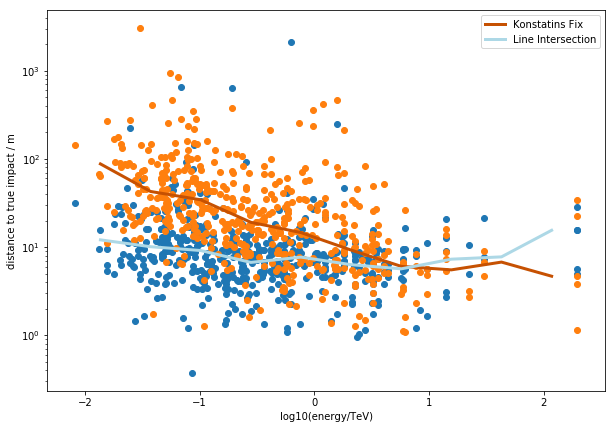

In [38]:
plt.figure(figsize=(10, 7))

from scipy.stats import binned_statistic

plt.scatter(np.log10(es), new_d)
plt.scatter(np.log10(es), old_d)
plt.yscale('log')
# plt.ylim(0, 75)

b_50, bin_edges, binnumber = binned_statistic(np.log10(es), old_d, statistic='median', bins=10, )
plt.plot(0.5 * (bin_edges[:-1] + bin_edges[1:]), b_50, color='xkcd:dark orange', lw=3, label='Konstatins Fix')

b_50, bin_edges, binnumber = binned_statistic(np.log10(es), new_d, statistic='median', bins=10, )
plt.plot(0.5 * (bin_edges[:-1] + bin_edges[1:]), b_50, color='lightblue', lw=3, label='Line Intersection')

plt.ylabel('distance to true impact / m')
plt.xlabel('log10(energy/TeV)')
plt.legend()
plt.savefig('impact_compare.png')

In [ ]:
plt.hexbin(es, new_d, xscale='log', yscale='log', gridsize=20)
plt.figure()
plt.hexbin(es, old_d, xscale='log', yscale='log', gridsize=20)

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Triggered 15 telescopes


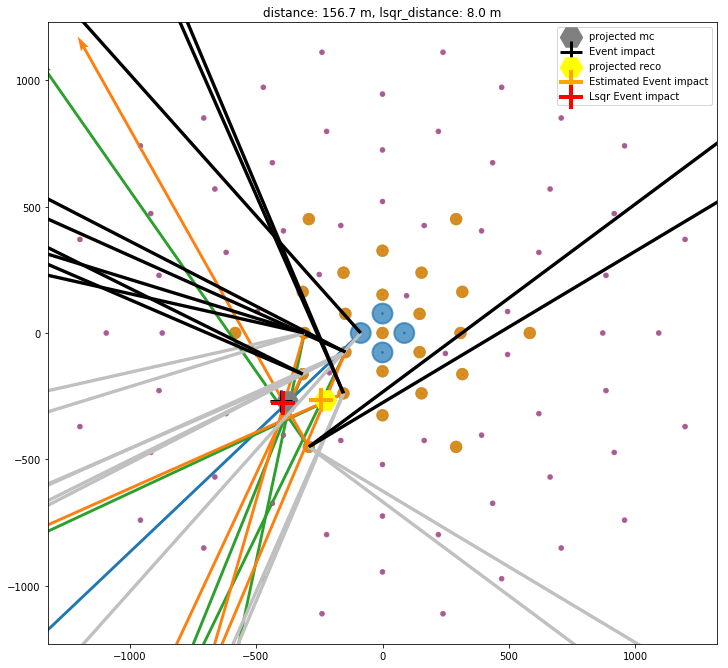

In [17]:
# Hillas reconstruction
for event in tqdm(events[:1]):
    cal.calibrate(event)
    hillas_reco = HillasReconstructor()
    reco, planes, hillas_dict = reconstruction(event)
    if not reco:
        continue
#     plt.figure()
    lsqr_impact = reconstruct_impact_position(hillas_dict, event.inst.subarray)
    plot_array_impact(event, hillas_dict, lsqr_impact)

In [16]:

def plot_array_impact(event, hillas_dict, lsqr_impact):
    print(f'Triggered {len(event.r0.tels_with_data)} telescopes')

    plt.figure(figsize=(12,12))
    array = ArrayDisplay(event.inst.subarray)
    array.set_vector_hillas(hillas_dict)


    point_dir = SkyCoord(
        *event.mcheader.run_array_direction,
        frame='altaz'
    )
    tiltedframe = TiltedGroundFrame(pointing_direction=point_dir)

    core_coord = SkyCoord(
        x=event.mc.core_x,
        y=event.mc.core_y,
        z = 0*u.m,
        frame=array.frame
    ).transform_to(tiltedframe)

    plt.scatter(core_coord.x.value, core_coord.y.value, marker = 'H', s=500, label='projected mc', color='gray')
    plt.scatter(event.mc.core_x, event.mc.core_y, marker = '+', color='black', s=500, linewidth=3, label="Event impact")

    core_coord = SkyCoord(
        x=reco.core_x,
        y=reco.core_y,
        z=0 * u.m,
        frame=array.frame
    ).transform_to(tiltedframe)
    plt.scatter(core_coord.x.value, core_coord.y.value, marker = 'H', s=500, label='projected reco', color='yellow')
    plt.scatter(reco.core_x, reco.core_y, marker = '+', color='orange', s=600, linewidth=4, label="Estimated Event impact")

    plt.scatter(lsqr_impact[0], lsqr_impact[1], marker = '+', color='red', s=600, linewidth=4, label="Lsqr Event impact")

    lsqr_distance = np.sqrt((event.mc.core_x - lsqr_impact[0] * u.m)**2 + (event.mc.core_y - lsqr_impact[1] * u.m)**2)
#     print(event.mc.alt.deg, event.mc.az.deg)
#     print(reco.alt.deg, reco.az.deg)

    distance = np.sqrt((event.mc.core_x - reco.core_x)**2 + (event.mc.core_y - reco.core_y)**2)
    plt.title(f'distance: {distance:0.1f}, lsqr_distance: {lsqr_distance:0.1f}')
    plt.legend()

    # for uvw, pos in zip(uvw_vectors, positions):
    #     plt.quiver(*pos[:2], *uvw[:2],  color='silver', scale=0.2, width=0.001)

    # for p, c in zip(mid_points, crossings):
    #     plt.quiver(*p[:2], *c[:2],  color='silver', scale=0.2, width=0.001)


    for p in planes.values():
    # #     plt.quiver(*p.pos[:2], *p.a[:2], color='gray', scale=0.01, width=0.005)
        plt.quiver(*p.pos[:2], *p.norm[:2],  color='silver', scale=0.2, width=0.005)
        n = p.norm
        n[1] *= -1
        plt.quiver(*p.pos[:2], *n[:2],  color='black', scale=0.2, width=0.005)
#         plt.quiver(*p.pos[:2], *(p.norm[:2]),  color='silver', scale=0.01, width=0.005)
#         plt.quiver(*p.pos[:2], *p.c[:2],  color='xkcd:dark gray', scale=0.01, width=0.005)
    # plt.savefig('array.png')